In [1]:
# ==============================================================================
# CELL 1: Environment Setup and Google Drive (Fine-Tuning Notebook)
# ==============================================================================
# Install modern, compatible libraries for fine-tuning
print("▸ Installing necessary libraries...")
!pip install -q "pytorch_lightning>=2.0.0" "timm>=0.9.0" segmentation-models-pytorch albumentations torchmetrics tifffile tqdm

# Mount Google Drive
print("\n▸ Mounting Google Drive...")
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    print("✓ Google Drive mounted.")
except Exception as e:
    print(f"🔥 Failed to mount Google Drive: {e}")

import torch
import pytorch_lightning as pl
print(f"\n✓ Setup complete. PyTorch {torch.__version__}, Lightning {pl.__version__}")

▸ Installing necessary libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00

In [2]:
# ==============================================================================
# CELL 2: Download STURM Data and Get SatMAE Code (Corrected)
# ==============================================================================
import os
import sys
import subprocess
from pathlib import Path
import requests
from tqdm.auto import tqdm


# --- 2b. Download and Patch SatMAE Code ---
REPO_DIR = "/content/SatMAE"
if not os.path.isdir(REPO_DIR):
    print("\n▸ Cloning and patching SatMAE repository...")
    subprocess.run(f"git clone --depth 1 https://github.com/sustainlab-group/SatMAE.git {REPO_DIR}", shell=True, check=True)
    PATCH_FILE_1 = os.path.join(REPO_DIR, "models_mae_group_channels.py")
    subprocess.run(f"sed -i 's/qk_scale=None, //g' {PATCH_FILE_1}", shell=True, check=True)
    print("✓ SatMAE code downloaded and patched.")

# Add to Python Path
if REPO_DIR not in sys.path:
    sys.path.insert(0, REPO_DIR)

# --- 2c. Define Checkpoint Directory ---
GDRIVE_CKPT_DIR = "/content/drive/MyDrive/satmae_ckpts"


▸ Cloning and patching SatMAE repository...
✓ SatMAE code downloaded and patched.


In [3]:
# ==============================================================================
# Cell 2: Automated Local Data Preparation (from Google Drive) - DEFINITIVE FIX
# PURPOSE: Copies dataset from GDrive, unzips, and correctly organizes the
#          Sentinel2/S2 and Sentinel2/Floodmaps subdirectories.
# ==============================================================================
from pathlib import Path
import shutil
import os

# --- Define Paths ---
# Source path in your Google Drive
GDRIVE_ZIP_PATH = Path('/content/drive/MyDrive/STURM/data/raw/STURM-Flood.zip')

# Local paths on the Colab machine for fast I/O
LOCAL_DATA_DIR = Path('/content/data')
LOCAL_IMAGES_DIR = LOCAL_DATA_DIR / 'images'
LOCAL_MASKS_DIR = LOCAL_DATA_DIR / 'masks'
LOCAL_ZIP_PATH = LOCAL_DATA_DIR / 'STURM-Flood.zip'
LOCAL_EXTRACTED_DIR = LOCAL_DATA_DIR / 'Dataset' # The root folder created by unzip
EXPECTED_FILE_COUNT = 2675

# --- Main Logic ---
print("--- Preparing Local Data Environment for this Session ---")

# Check if data is already prepared on the local disk to avoid re-copying
if LOCAL_IMAGES_DIR.is_dir() and len(list(LOCAL_IMAGES_DIR.glob('*.tif'))) == EXPECTED_FILE_COUNT and \
   LOCAL_MASKS_DIR.is_dir() and len(list(LOCAL_MASKS_DIR.glob('*.tif'))) == EXPECTED_FILE_COUNT:
    print("✅ Data is already prepared on the local disk.")
else:
    print(f"⚠️ Data not found or incomplete on local disk. Starting fresh setup...")

    # Clean up any partial setup first
    if LOCAL_DATA_DIR.exists():
        shutil.rmtree(LOCAL_DATA_DIR)

    LOCAL_DATA_DIR.mkdir(parents=True, exist_ok=True)

    # 1. Copy the ZIP file from Google Drive to the local Colab disk
    print(f"   -> Copying master ZIP from GDrive to {LOCAL_ZIP_PATH}...")
    if not GDRIVE_ZIP_PATH.exists():
        raise FileNotFoundError(f"CRITICAL: The source ZIP was not found at {GDRIVE_ZIP_PATH}. Please check the path.")
    shutil.copy(GDRIVE_ZIP_PATH, LOCAL_ZIP_PATH)
    print("   -> Copy complete.")

    # 2. Unzip locally
    print(f"   -> Extracting ZIP locally...")
    # This creates /content/data/Dataset/...
    !unzip -q -o {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}

    # 3. Organize files into a simple images/ and masks/ structure
    print("   -> Organizing files from extracted structure...")

    # --- CORRECTED SOURCE PATHS ---
    # The actual paths after unzipping based on your description
    source_images_path = LOCAL_EXTRACTED_DIR / 'Sentinel2/S2'
    source_masks_path = LOCAL_EXTRACTED_DIR / 'Sentinel2/Floodmaps'
    # --- END CORRECTION ---

    if not source_images_path.exists() or not source_masks_path.exists():
        raise FileNotFoundError(f"Unzip structure mismatch. Could not find {source_images_path} or {source_masks_path}")

    # Move the files from the nested structure to the clean top-level dirs
    # os.rename is more efficient than `!mv` for this
    os.rename(source_images_path, LOCAL_IMAGES_DIR)
    os.rename(source_masks_path, LOCAL_MASKS_DIR)

    # 4. Clean up large intermediate files to save space
    print("   -> Cleaning up...")
    shutil.rmtree(LOCAL_EXTRACTED_DIR) # This removes the now-empty parent 'Dataset' folder
    # LOCAL_ZIP_PATH.unlink() # Optional: uncomment to delete the local zip copy

    print("✅ Local data preparation complete.")


--- Preparing Local Data Environment for this Session ---
⚠️ Data not found or incomplete on local disk. Starting fresh setup...
   -> Copying master ZIP from GDrive to /content/data/STURM-Flood.zip...
   -> Copy complete.
   -> Extracting ZIP locally...
   -> Organizing files from extracted structure...
   -> Cleaning up...
✅ Local data preparation complete.


In [4]:
# --- Final Verification ---
num_images = len(list(LOCAL_IMAGES_DIR.glob('*.tif')))
num_masks = len(list(LOCAL_MASKS_DIR.glob('*.tif')))

print(f"\nVerification: Found {num_images} images and {num_masks} masks on local disk.")
assert num_images == EXPECTED_FILE_COUNT and num_masks == EXPECTED_FILE_COUNT, "File count mismatch after preparation!"

# --- Cell A: Build 0.5% event-wise split and dataloaders ---

import numpy as np
import torch
import tifffile
from pathlib import Path
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# Restore deprecated alias for timm
np.float = np.float64

# Paths to Sentinel‑2 images and masks
S2_DIR    = Path('/content/drive/MyDrive/STURM/data/raw/Dataset/Sentinel2/S2')
FLOOD_DIR = Path('/content/drive/MyDrive/STURM/data/raw/Dataset/Sentinel2/Floodmaps')
all_image_paths = sorted(S2_DIR.rglob('*.tif'))

# (Re)compute mean and std over all 9 bands (NaN-safe)
n_bands = 9
sum_pixels    = np.zeros(n_bands)
sum_sq_pixels = np.zeros(n_bands)
count_pixels  = np.zeros(n_bands)
for p in tqdm(all_image_paths):
    img = tifffile.imread(p).astype(np.float64)
    if img.ndim == 3 and img.shape[-1] < img.shape[0]:
        img = img.transpose(2,0,1)
    sum_pixels    += np.nansum(img, axis=(1,2))
    sum_sq_pixels += np.nansum(img**2, axis=(1,2))
    count_pixels  += np.count_nonzero(~np.isnan(img), axis=(1,2))
dataset_mean = sum_pixels / count_pixels
dataset_std  = np.sqrt(sum_sq_pixels / count_pixels - dataset_mean**2)

# Group image paths by event ID (prefix before first underscore)
def get_event_id(p: Path) -> str:
    return p.name.split('_')[0]
event_to_paths = {}
for p in all_image_paths:
    event_id = get_event_id(p)
    event_to_paths.setdefault(event_id, []).append(p)

# Select smallest events until the number of tiles ≈ 0.5% of the total
total_tiles  = len(all_image_paths)
target_count = max(1, int(0.005 * total_tiles))  # ensure at least one event
events_sorted = sorted(event_to_paths.keys(), key=lambda ev: len(event_to_paths[ev]))
selected_events = []
cumulative = 0
for ev in events_sorted:
    if cumulative + len(event_to_paths[ev]) <= target_count:
        selected_events.append(ev)
        cumulative += len(event_to_paths[ev])
    else:
        break

train_paths = []
val_paths   = []
for ev, paths in event_to_paths.items():
    (train_paths if ev in selected_events else val_paths).extend(paths)

print(f"Selected events: {selected_events}")
print(f"Training tiles: {len(train_paths)} ({100*len(train_paths)/total_tiles:.2f}% of dataset)")
print(f"Validation tiles: {len(val_paths)}")

# Dataset class (correct transform handling)
class FloodDataset(Dataset):
    def __init__(self, paths, mean, std, transform=None):
        self.paths = paths
        self.mean  = torch.from_numpy(mean).float().view(-1,1,1)
        self.std   = torch.from_numpy(std + 1e-6).float().view(-1,1,1)
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img  = tifffile.imread(img_path).astype(np.float32)
        if img.ndim == 3 and img.shape[-1] < img.shape[0]:
            img = img.transpose(2,0,1)
        mask = (tifffile.imread(FLOOD_DIR / img_path.name) > 0).astype(np.uint8)

        tensor = torch.from_numpy(img)
        tensor = (tensor - self.mean) / self.std
        tensor = torch.nan_to_num(tensor, nan=0.0)

        if self.transform:
            # Albumentations expects HWC numpy; returns CHW torch tensors
            aug = self.transform(image=tensor.permute(1,2,0).numpy(), mask=mask)
            tensor = aug['image']  # CHW tensor
            mask   = aug['mask']   # HW tensor
        else:
            mask = torch.from_numpy(mask)

        return tensor.float(), mask.long()

# Transforms (resize to 128×128 for SatMAE)
train_tf = A.Compose([
    A.Resize(128,128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(transpose_mask=True)
], is_check_shapes=False)

val_tf = A.Compose([
    A.Resize(128,128),
    ToTensorV2(transpose_mask=True)
], is_check_shapes=False)

# Create datasets and loaders
train_ds  = FloodDataset(train_paths, dataset_mean, dataset_std, transform=train_tf)
val_ds    = FloodDataset(val_paths,   dataset_mean, dataset_std, transform=val_tf)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2)

print(f"0.5% split: {len(train_paths)} training samples, {len(val_paths)} validation samples.")


Verification: Found 2675 images and 2675 masks on local disk.


Selected events: ['EMSR488', 'EMSR496', 'EMSR444']
Training tiles: 12 (0.45% of dataset)
Validation tiles: 2663
0.5% split: 12 training samples, 2663 validation samples.


In [5]:
# ==============================================================================
# Cell: Train a U‑Net/ResNet model on the 0.5% STURM split
# ==============================================================================

import pytorch_lightning as pl
import torch
import tifffile
from pathlib import Path
from torchmetrics import F1Score
import segmentation_models_pytorch as smp

# ------------------------------------------------------------------
# 1) Compute class weight α for Focal loss (non‑water / total pixels)
total_water = 0
total_nonwater = 0
for p in train_paths:
    mask = tifffile.imread(FLOOD_DIR / p.name)
    total_water += (mask > 0).sum()
    total_nonwater += (mask == 0).sum()
alpha = total_nonwater / (total_water + total_nonwater)
print(f"Alpha (non‑water fraction) for Focal loss: {alpha:.3f}")

# ------------------------------------------------------------------
# 2) Define the Lightning module wrapping a U‑Net with a ResNet34 encoder
class UNetResNetFineTuner(pl.LightningModule):
    def __init__(self, in_channels=9, lr=3e-4, alpha=alpha, gamma=2.0):
        super().__init__()
        self.save_hyperparameters()
        # Build U‑Net with ResNet34 backbone; no pretrained weights because of 9 channels
        self.model = smp.Unet(
            encoder_name='resnet34',
            encoder_weights=None,
            in_channels=in_channels,
            classes=1
        )
        # Weighted Focal loss to handle class imbalance
        self.loss_fn = smp.losses.FocalLoss(mode='binary', alpha=alpha, gamma=gamma)
        self.val_f1  = F1Score(task='binary', threshold=0.5)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1).float()
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1).float()
        logits = self(x)
        self.val_f1.update(logits, y.int())
        self.log('val_loss', self.loss_fn(logits, y))

    def on_validation_epoch_end(self):
        f1 = self.val_f1.compute()
        self.log('val_f1_water', f1, prog_bar=True)
        self.val_f1.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

# ------------------------------------------------------------------
# 3) Instantiate the model and set up the trainer
unet_model = UNetResNetFineTuner(in_channels=9, lr=3e-4, alpha=alpha, gamma=2.0)

# Create output directory for checkpoints
UNET_SAVE_DIR = Path('/content/drive/MyDrive/satmae_pretrain_ckpts/unet_eventwise_0_5percent')
UNET_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Early stopping and model checkpointing
early_stop = pl.callbacks.EarlyStopping(
    monitor='val_f1_water',
    patience=10,
    mode='max',
    verbose=True
)
checkpoint_cb = pl.callbacks.ModelCheckpoint(
    monitor='val_f1_water',
    mode='max',
    save_top_k=1,
    dirpath=UNET_SAVE_DIR,
    filename='unet-resnet-0_5p-best-{epoch}-{val_f1_water:.4f}'
)

# Trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='auto',
    devices=1,
    accumulate_grad_batches=2,  # effective batch size = 32
    log_every_n_steps=1,
    callbacks=[early_stop, checkpoint_cb]
)

# ------------------------------------------------------------------
# 4) Train the model on the 0.5% event-wise data split
print("\n🚀 Starting U‑Net fine‑tuning on the 0.5% STURM split...")
trainer.fit(unet_model, train_loader, val_loader)
print("\n🎉 U‑Net training complete!")
print(f"Best model saved to: {checkpoint_cb.best_model_path}")


total_updates = trainer.global_step
print("Total optimiser updates:", total_updates)

Alpha (non‑water fraction) for Focal loss: 0.910


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision



🚀 Starting U‑Net fine‑tuning on the 0.5% STURM split...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | Unet          | 24.5 M | train
1 | loss_fn | FocalLoss     | 0      | train
2 | val_f1  | BinaryF1Score | 0      | train
--------------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.821    Total estimated model params size (MB)
190       Modules in train mode
0         Modules in eval mode


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved. New best score: 0.268


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.041 >= min_delta = 0.0. New best score: 0.309


INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_f1_water did not improve in the last 10 records. Best score: 0.309. Signaling Trainer to stop.



🎉 U‑Net training complete!
Best model saved to: /content/drive/MyDrive/satmae_pretrain_ckpts/unet_eventwise_0_5percent/unet-resnet-0_5p-best-epoch=1-val_f1_water=0.3091.ckpt
Total optimiser updates: 12


In [6]:
# =======================================================================================
# CELL B: Define Hybrid Model with a Custom U-Net Style Decoder (Corrected Validation)
# =======================================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import F1Score
from pathlib import Path

# --- Import the SatMAE model definition from the cloned repository ---
from models_mae_group_channels import mae_vit_base_patch16_dec512d8b as mae_factory

print("▸ Defining model architectures with a custom decoder...")

# --- 1. A dummy LightningModule to correctly load the pre-trained SatMAE weights ---
class SatMAE_Loader(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.model = mae_factory(img_size=128, in_chans=9, channel_groups=[[0,1,2],[3,4,5],[6,7,8]])


# --- 2. A simple but effective Convolutional Block for the decoder ---
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)


# --- 3. The Hybrid Fine-Tuner with our own U-Net style decoder ---
class SatMAE_CustomDecoder_Finetuner(pl.LightningModule):
    def __init__(self, satmae_core_model, learning_rate=3e-4):
        super().__init__()
        self.save_hyperparameters(ignore=['satmae_core_model'])

        self.mae_model = satmae_core_model
        self.mae_model.eval()
        for param in self.mae_model.parameters():
            param.requires_grad = False

        encoder_embed_dim = getattr(self.mae_model, "embed_dim", 768)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.decoder_conv1 = ConvBlock(encoder_embed_dim, 256)
        self.decoder_conv2 = ConvBlock(256 + 64, 128)
        self.skip_proj = ConvBlock(9, 64)
        self.segmentation_head = nn.Conv2d(128, 1, kernel_size=1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.val_f1 = F1Score(task='binary', threshold=0.5)

    def forward(self, x):
        with torch.no_grad():
            tokens, _, _ = self.mae_model.forward_encoder(x, mask_ratio=0.0)
        tokens = tokens[:, 1:, :]
        G = len(self.mae_model.channel_groups); B, N, C = tokens.shape
        H = W = int((N // G) ** 0.5)
        vit_features = tokens.view(B, G, H, W, C).mean(dim=1).permute(0, 3, 1, 2).contiguous()
        skip_features = self.skip_proj(F.interpolate(x, scale_factor=0.125, mode='bilinear'))
        d1 = self.upsample(vit_features)
        d1 = self.decoder_conv1(d1)
        d2 = torch.cat([d1, skip_features], dim=1)
        d2 = self.decoder_conv2(d2)
        out = F.interpolate(d2, size=x.shape[-2:], mode='bilinear', align_corners=True)
        logits = self.segmentation_head(out)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1).float())
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # ⭐ FIX: Add the channel dimension to the target 'y' before passing to the metric.
        # This makes its shape [16, 1, 128, 128] to match the logits.
        self.val_f1.update(logits, y.unsqueeze(1).int())

    def on_validation_epoch_end(self):
        f1 = self.val_f1.compute()
        self.log('val_f1_water', f1, prog_bar=True)
        self.val_f1.reset()

    def configure_optimizers(self):
        params_to_train = list(self.decoder_conv1.parameters()) + \
                          list(self.decoder_conv2.parameters()) + \
                          list(self.skip_proj.parameters()) + \
                          list(self.segmentation_head.parameters())
        return torch.optim.Adam(params_to_train, lr=self.hparams.learning_rate)

print("✓ Hybrid model with custom decoder is defined (validation step corrected).")

# ==============================================================================
# CELL C: Execute Fine-Tuning with the Custom Decoder Model
# ==============================================================================
import pytorch_lightning as pl
from pathlib import Path

# --- Configuration ---
PRETRAINED_CHECKPOINT = "/content/drive/MyDrive/satmae_pretrain_ckpts/mae9_epoch20.ckpt"
GDRIVE_SAVE_DIR = Path('/content/drive/MyDrive/satmae_ckpts')
LEARNING_RATE = 3e-4

# --- Model Loading & Initialization ---
print(f"--- Loading pre-trained SatMAE encoder ---")
print(f"Source: {Path(PRETRAINED_CHECKPOINT).name}")

if not Path(PRETRAINED_CHECKPOINT).exists():
    raise FileNotFoundError(f"CRITICAL: The SatMAE checkpoint was not found at {PRETRAINED_CHECKPOINT}. Please verify the path.")

mae_loader = SatMAE_Loader.load_from_checkpoint(PRETRAINED_CHECKPOINT, strict=False)
satmae_core_model = mae_loader.model
print("✓ SatMAE core model extracted.")

# Initialize our new, self-contained fine-tuning class
finetune_model = SatMAE_CustomDecoder_Finetuner(
    satmae_core_model=satmae_core_model,
    learning_rate=LEARNING_RATE
)
print("✓ Custom Decoder Fine-tuner initialized.")

# --- Trainer Setup ---
early_stopping_callback = pl.callbacks.EarlyStopping(monitor="val_f1_water", patience=10, mode="max", verbose=True)

ft_trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    devices=1,
    callbacks=[
        early_stopping_callback,
        pl.callbacks.ModelCheckpoint(
            monitor='val_f1_water',
            mode='max',
            save_top_k=1,
            dirpath=GDRIVE_SAVE_DIR / 'finetuned_custom_decoder', # Save to a new folder
            filename='satmae-CustomDecoder-finetuned-0_5p-best-{epoch}-{val_f1_water:.4f}'
        )
    ]
)

# --- Start Training ---
print("\n🚀 --- Starting Fine-tuning (SatMAE Encoder + Custom Decoder) on 0.5% event-wise split ---")
ft_trainer.fit(finetune_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

print("\n🎉 Fine-tuning complete! ---")
print(f"🏆 Best model saved with Validation F1 score: {early_stopping_callback.best_score:.4f}")
if ft_trainer.checkpoint_callback:
    print(f"   Model path: {ft_trainer.checkpoint_callback.best_model_path}")

▸ Defining model architectures with a custom decoder...
✓ Hybrid model with custom decoder is defined (validation step corrected).
--- Loading pre-trained SatMAE encoder ---
Source: mae9_epoch20.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


✓ SatMAE core model extracted.
✓ Custom Decoder Fine-tuner initialized.

🚀 --- Starting Fine-tuning (SatMAE Encoder + Custom Decoder) on 0.5% event-wise split ---


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /content/drive/MyDrive/satmae_ckpts/finetuned_custom_decoder exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                             | Params | Mode 
-------------------------------------------------------------------------------
0 | mae_model         | MaskedAutoencoderGroupChannelViT | 113 M  | eval 
1 | upsample          | Upsample                         | 0      | train
2 | decoder_conv1     | ConvBlock                        | 2.4 M  | train
3 | decoder_conv2     | ConvBlock                        | 516 K  | train
4 | skip_proj         | ConvBlock                        | 42.3 K | train
5 | segmentation_head | Conv2d                           | 129    | train
6 | loss_fn           | BCEWithLogitsLoss                | 0      | tra

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved. New best score: 0.000


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.264 >= min_delta = 0.0. New best score: 0.264


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.192 >= min_delta = 0.0. New best score: 0.456


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.066 >= min_delta = 0.0. New best score: 0.522


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.016 >= min_delta = 0.0. New best score: 0.538


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.016 >= min_delta = 0.0. New best score: 0.554


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.009 >= min_delta = 0.0. New best score: 0.563


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.000 >= min_delta = 0.0. New best score: 0.563


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.006 >= min_delta = 0.0. New best score: 0.569


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.014 >= min_delta = 0.0. New best score: 0.583


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.005 >= min_delta = 0.0. New best score: 0.588


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.057 >= min_delta = 0.0. New best score: 0.645


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.018 >= min_delta = 0.0. New best score: 0.663


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.018 >= min_delta = 0.0. New best score: 0.682


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.037 >= min_delta = 0.0. New best score: 0.719


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.001 >= min_delta = 0.0. New best score: 0.720


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.003 >= min_delta = 0.0. New best score: 0.723


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.010 >= min_delta = 0.0. New best score: 0.734


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.002 >= min_delta = 0.0. New best score: 0.736


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.000 >= min_delta = 0.0. New best score: 0.736


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.014 >= min_delta = 0.0. New best score: 0.750


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1_water improved by 0.002 >= min_delta = 0.0. New best score: 0.752


INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_f1_water did not improve in the last 10 records. Best score: 0.752. Signaling Trainer to stop.



🎉 Fine-tuning complete! ---
🏆 Best model saved with Validation F1 score: 0.7522
   Model path: /content/drive/MyDrive/satmae_ckpts/finetuned_custom_decoder/satmae-CustomDecoder-finetuned-0_5p-best-epoch=26-val_f1_water=0.7522.ckpt


▸ Loading SatMAE Hybrid model for inference...
✓ Model loaded successfully.

▸ Running inference on validation sample #1331...
✓ Inference complete.


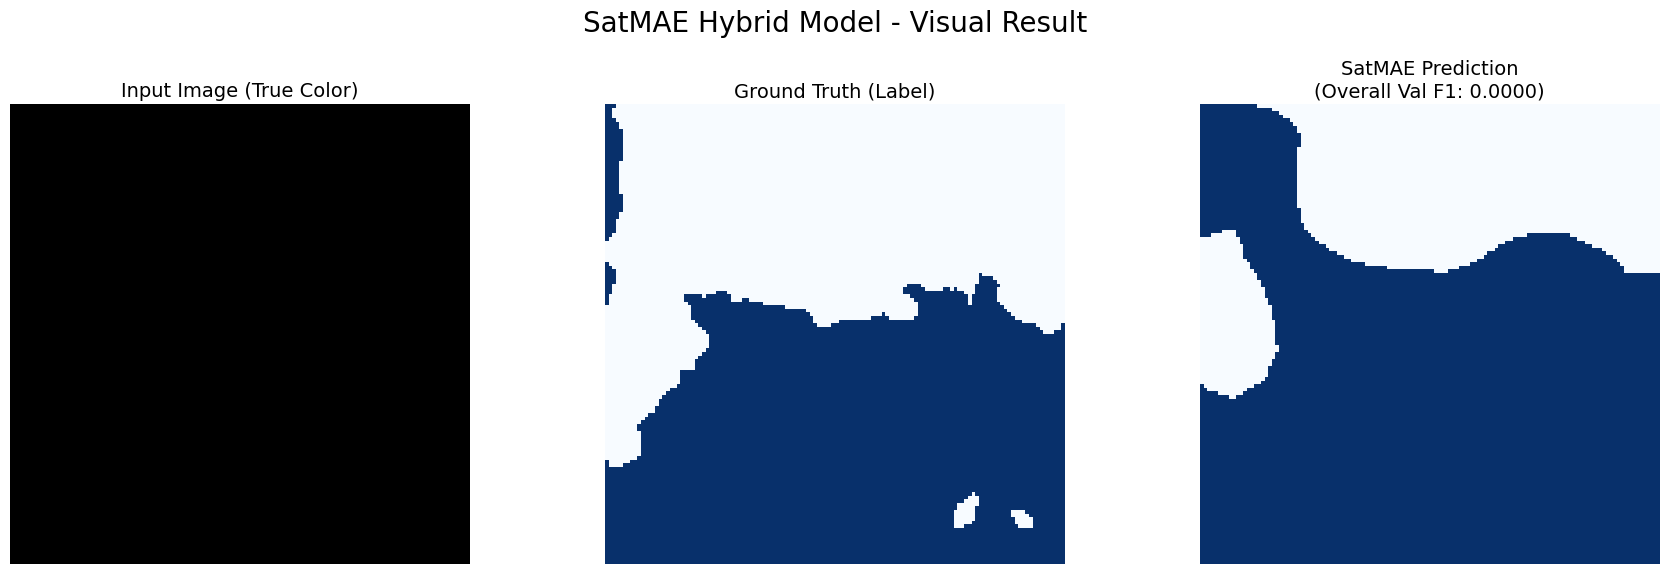

In [8]:
# ==============================================================================
# CELL D: Visualize SatMAE Hybrid Model Results
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path

# --- Configuration ---
# ⚠️ ACTION REQUIRED: Update this path with the one printed at the end of the previous cell (Cell C).
# The path below is a placeholder that matches the new naming convention.
SATMAE_MODEL_PATH = "/content/drive/MyDrive/satmae_ckpts/finetuned_custom_decoder/satmae-CustomDecoder-finetuned-0_5p-best-epoch=26-val_f1_water=0.7522.ckpt" # <-- UPDATE THIS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- IMPORTANT: You must have the model class definitions available ---
# This cell assumes you have already run "Cell B" which defines:
# - SatMAE_Loader
# - SatMAE_CustomDecoder_Finetuner
# If you get a "NameError", re-run that cell first.

print("▸ Loading SatMAE Hybrid model for inference...")

# Check if the model file exists before trying to load it
if not Path(SATMAE_MODEL_PATH).exists():
    raise FileNotFoundError(f"CRITICAL: The model checkpoint was not found at {SATMAE_MODEL_PATH}. Please verify the path and update it if needed.")

try:
    # Load the SatMAE Hybrid model from the saved checkpoint
    # We pass a dummy `satmae_core_model` because it's required by the __init__ method,
    # but the actual weights for the core model will be loaded from the checkpoint file.
    model = SatMAE_CustomDecoder_Finetuner.load_from_checkpoint(
        SATMAE_MODEL_PATH,
        satmae_core_model=SatMAE_Loader().model
    ).to(DEVICE)
    model.eval() # Set the model to evaluation mode (disables dropout, etc.)
    print("✓ Model loaded successfully.")
except Exception as e:
    print(f"🔥 An error occurred while loading the model: {e}")
    print("   Please ensure you have run 'Cell B' to define the model class and updated the SATMAE_MODEL_PATH variable.")


# --- Inference Function ---
def predict(model, image_tensor):
    """Runs a single image tensor through a model for prediction."""
    with torch.no_grad(): # Disable gradient calculations for speed
        # Add a batch dimension (B, C, H, W) and send to the GPU/CPU
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE)

        # Get model output (these are raw logits)
        logits = model(input_tensor)

        # Convert logits to probabilities (0 to 1) using the sigmoid function
        probabilities = torch.sigmoid(logits)

        # Convert probabilities to a binary mask (0 or 1) using a 0.5 threshold
        # .squeeze() removes the batch and channel dimensions
        # .cpu().numpy() moves the tensor to the CPU and converts to a NumPy array for plotting
        predicted_mask = (probabilities > 0.5).squeeze().cpu().numpy()
    return predicted_mask

# --- Visualization ---
# Get a sample from your validation dataset (`val_ds` was created in Cell A)
# Let's pick a sample from the middle of the validation set for a typical example
sample_idx = len(val_ds) // 2
image_tensor, ground_truth_mask = val_ds[sample_idx]

print(f"\n▸ Running inference on validation sample #{sample_idx}...")
# Run inference with the loaded model
predicted_mask = predict(model, image_tensor)
print("✓ Inference complete.")

# --- Plotting the results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle("SatMAE Hybrid Model - Visual Result", fontsize=20)

# To display the image, we need to select the right bands and adjust contrast.
# The `ToTensorV2` augmentation resulted in a tensor with shape (C, H, W).
# We select Sentinel-2 bands B4 (Red), B3 (Green), and B2 (Blue) for a true-color view.
# These correspond to indices 2, 1, 0 in your 9-band stack if it's ordered B2,B3,B4,B8...
# Note: `dataset_mean` and `dataset_std` must be available from Cell A.
# We will "un-normalize" for a more natural look.
unnormalized_img = (image_tensor.numpy() * dataset_std.reshape(-1, 1, 1)) + dataset_mean.reshape(-1, 1, 1)
# Select RGB bands (indices 2, 1, 0), clip values to a reasonable range for better visualization, and scale to 0-1.
rgb_img = np.clip(unnormalized_img[[2, 1, 0], :, :], 0, 3000) / 3000

# Transpose from (C, H, W) to (H, W, C) for Matplotlib
axes[0].imshow(rgb_img.transpose(1, 2, 0))
axes[0].set_title("Input Image (True Color)", fontsize=14)
axes[0].axis('off')

axes[1].imshow(ground_truth_mask.numpy(), cmap='Blues')
axes[1].set_title("Ground Truth (Label)", fontsize=14)
axes[1].axis('off')

# The title will automatically display the F1 score from the loaded model's hyperparameters
axes[2].imshow(predicted_mask, cmap='Blues')
axes[2].set_title(f"SatMAE Prediction\n(Overall Val F1: {model.hparams.get('val_f1_water', 0.0):.4f})", fontsize=14)
axes[2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

▸ Loading SatMAE Hybrid model for inference...
✓ Model loaded successfully.

▸ Displaying 4 random examples from validation set indices: [1805, 982, 1216, 560]


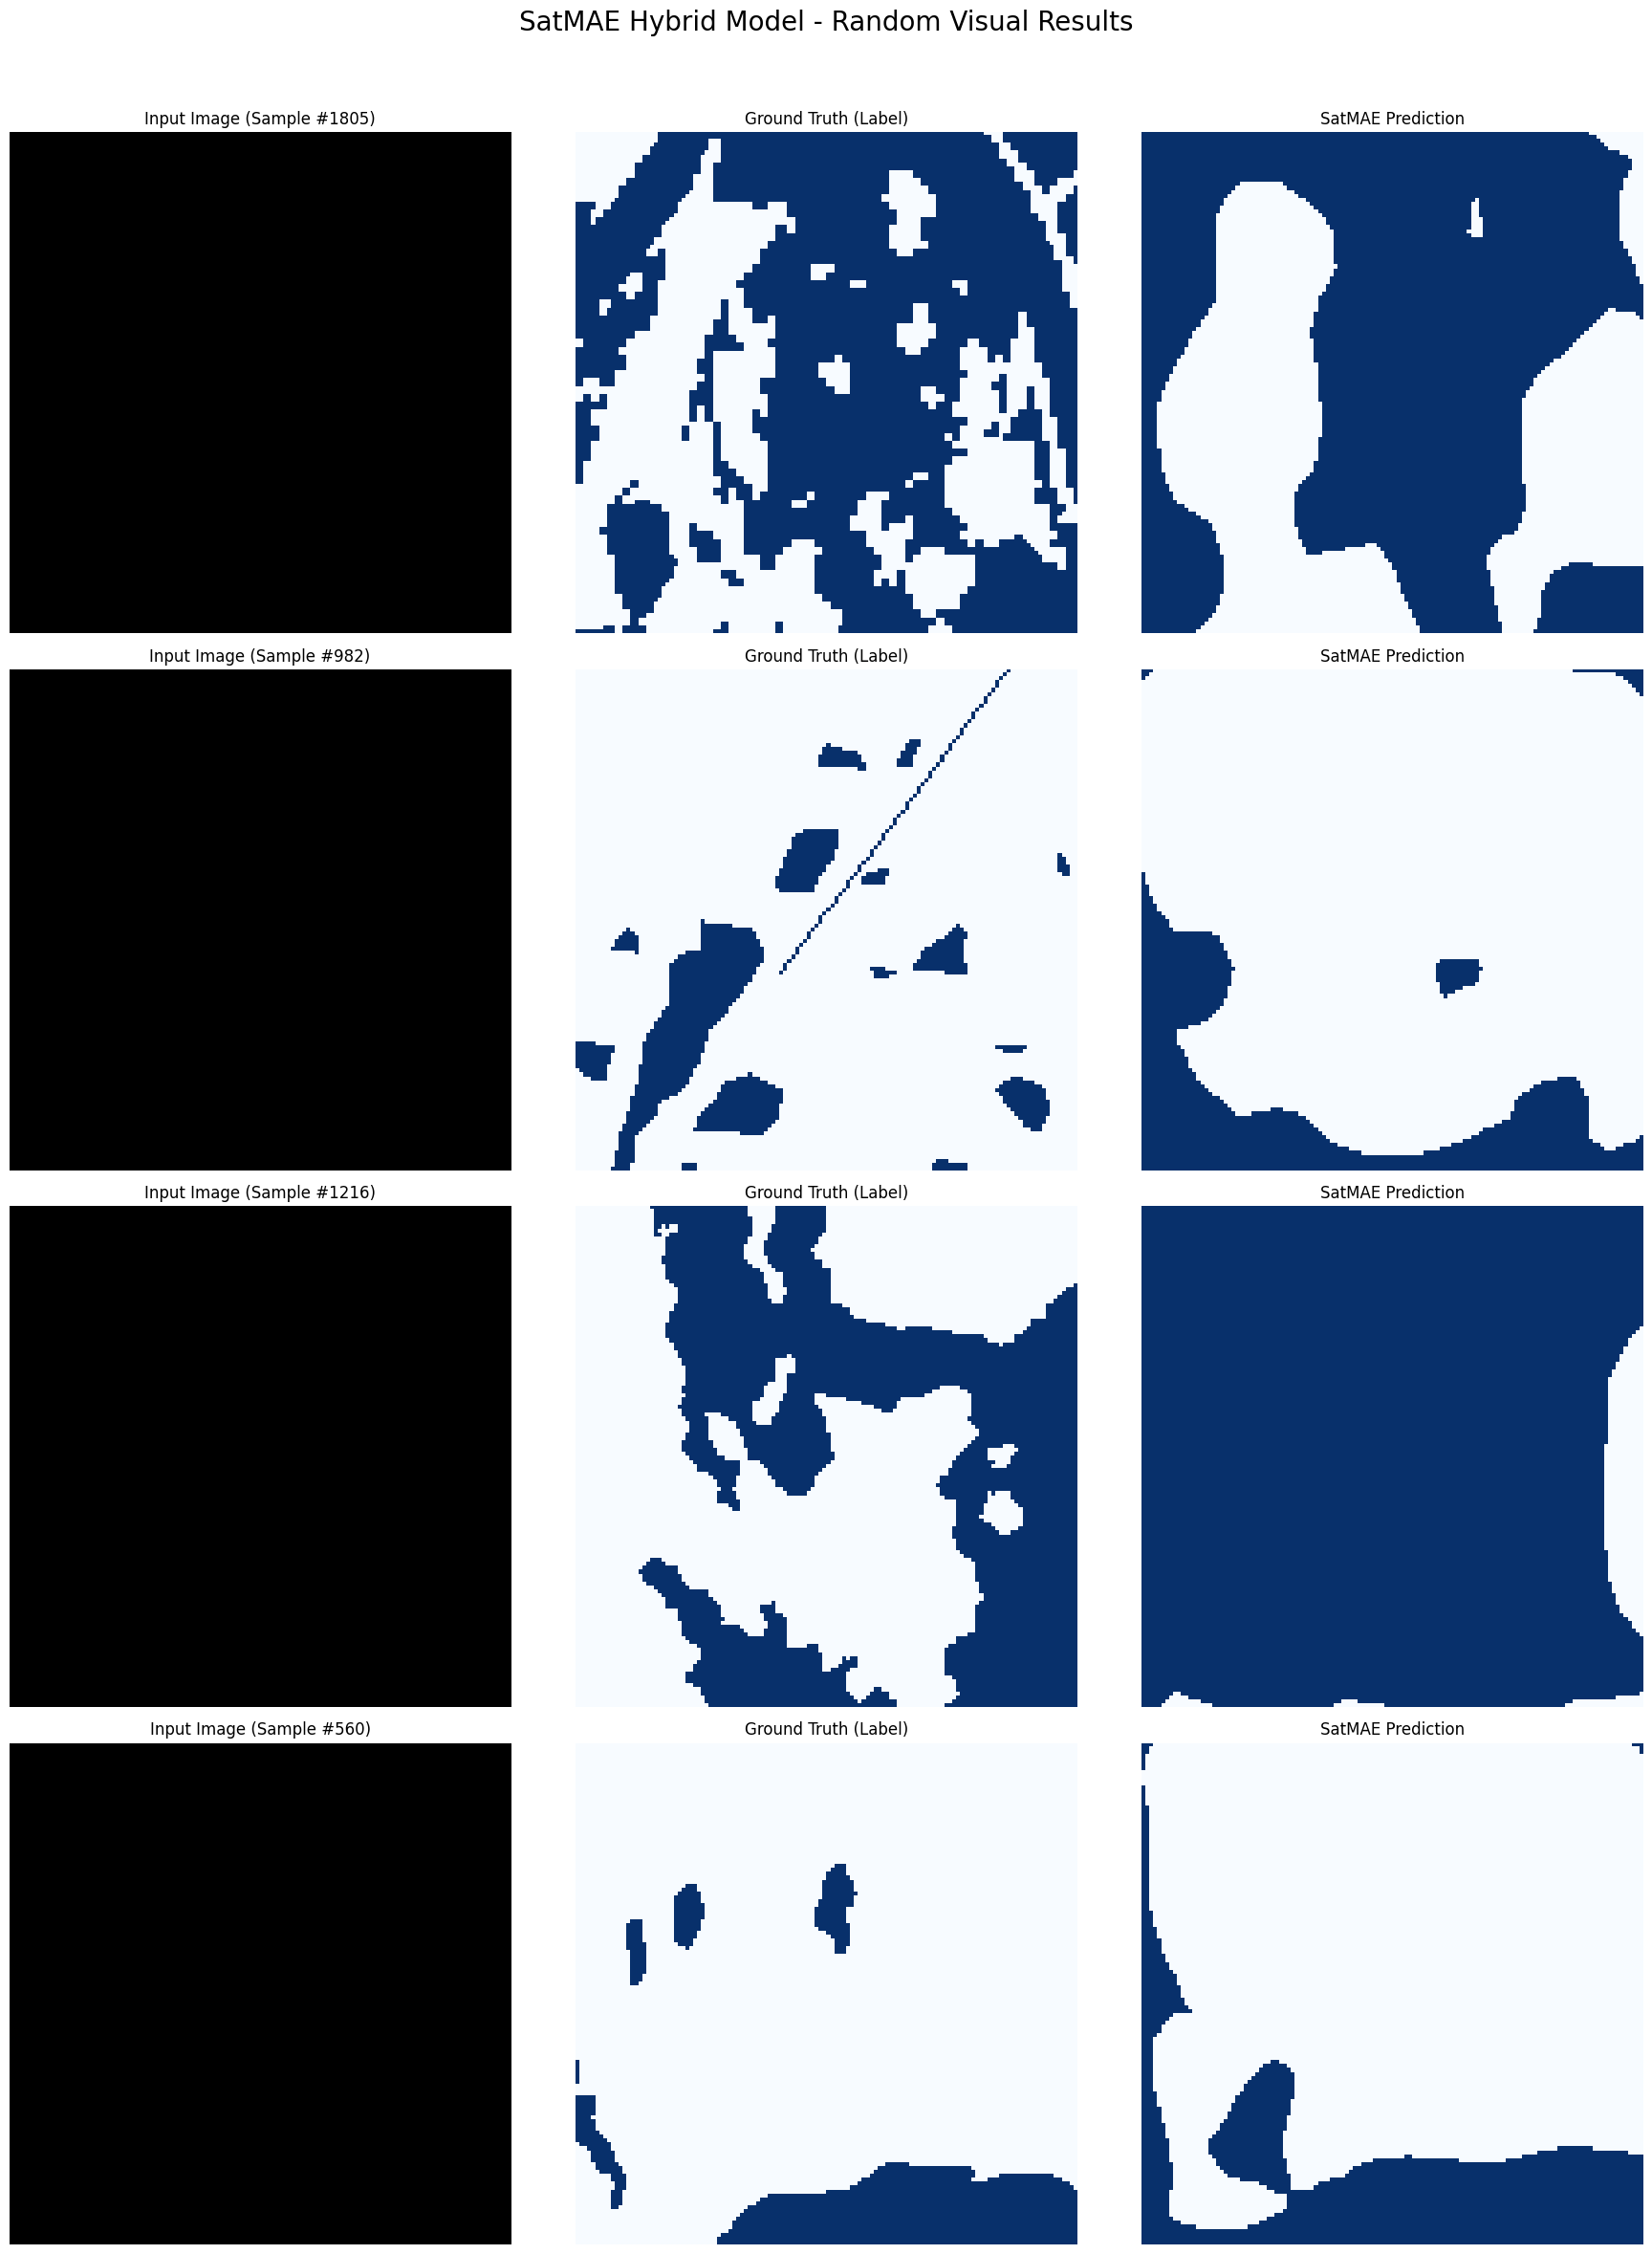

In [11]:
# ==============================================================================
# CELL D (Upgraded): Visualize Multiple Random Examples
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import random

# --- Configuration ---
# ⚠️ ACTION REQUIRED: This path should be the same as the one you updated in the cell above.
SATMAE_MODEL_PATH = "/content/drive/MyDrive/satmae_ckpts/finetuned_custom_decoder/satmae-CustomDecoder-finetuned-0_5p-best-epoch=26-val_f1_water=0.7522.ckpt" # <-- This path is correctly updated
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EXAMPLES = 4 # How many random examples to show

# --- IMPORTANT: Ensure model classes from "Cell B" are defined ---
# This cell requires SatMAE_Loader and SatMAE_CustomDecoder_Finetuner

print("▸ Loading SatMAE Hybrid model for inference...")
if not Path(SATMAE_MODEL_PATH).exists():
    raise FileNotFoundError(f"CRITICAL: The model checkpoint was not found at {SATMAE_MODEL_PATH}. Please verify the path and update it if needed.")

try:
    model = SatMAE_CustomDecoder_Finetuner.load_from_checkpoint(
        SATMAE_MODEL_PATH,
        satmae_core_model=SatMAE_Loader().model
    ).to(DEVICE)
    model.eval()
    print("✓ Model loaded successfully.")
except Exception as e:
    print(f"🔥 An error occurred while loading the model: {e}")
    raise

# --- Inference Function (remains the same) ---
def predict(model, image_tensor):
    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE)
        logits = model(input_tensor)
        probabilities = torch.sigmoid(logits)
        predicted_mask = (probabilities > 0.5).squeeze().cpu().numpy()
    return predicted_mask

# --- Main Visualization Function ---
def show_random_examples(dataset, model, num_examples=4):
    """
    Selects, predicts, and displays a grid of random examples.
    """
    if len(dataset) < num_examples:
        print(f"Warning: Requested {num_examples} examples, but validation set only has {len(dataset)} samples.")
        num_examples = len(dataset)

    # Randomly select indices from the validation dataset
    random_indices = random.sample(range(len(dataset)), num_examples)
    print(f"\n▸ Displaying {num_examples} random examples from validation set indices: {random_indices}")

    # Create a subplot grid
    fig, axes = plt.subplots(num_examples, 3, figsize=(18, 6 * num_examples))
    # Adjust title position if there's only one row
    suptitle_y = 0.98 if num_examples > 1 else 1.05
    fig.suptitle("SatMAE Hybrid Model - Random Visual Results", fontsize=20, y=suptitle_y)


    for i, idx in enumerate(random_indices):
        # Get the data
        image_tensor, ground_truth_mask = dataset[idx]

        # Get model prediction
        predicted_mask = predict(model, image_tensor)

        # --- Display Logic ---
        # Un-normalize for display. `dataset_mean` and `dataset_std` must be available from Cell A
        unnormalized_img = (image_tensor.numpy() * dataset_std.reshape(-1, 1, 1)) + dataset_mean.reshape(-1, 1, 1)
        # Select RGB bands (indices 2,1,0), clip for contrast, and scale to 0-1 range
        rgb_img = np.clip(unnormalized_img[[2, 1, 0], :, :], 0, 3000) / 3000

        # Plot Input Image
        ax = axes[i, 0] if num_examples > 1 else axes[0]
        ax.imshow(rgb_img.transpose(1, 2, 0))
        ax.set_title(f"Input Image (Sample #{idx})")
        ax.axis('off')

        # Plot Ground Truth
        ax = axes[i, 1] if num_examples > 1 else axes[1]
        ax.imshow(ground_truth_mask.numpy(), cmap='Blues')
        ax.set_title("Ground Truth (Label)")
        ax.axis('off')

        # Plot Model Prediction
        ax = axes[i, 2] if num_examples > 1 else axes[2]
        ax.imshow(predicted_mask, cmap='Blues')
        ax.set_title("SatMAE Prediction")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- Run the visualization ---
# You can run this cell multiple times to get new random examples.
# `val_ds` must be the validation dataset created in your data preparation cell (Cell A).
show_random_examples(val_ds, model, num_examples=NUM_EXAMPLES)

# The problematic code block below has been removed.